# Predicting Financial Time Series Data with Machine Learning

This is a sample that predicts future prices from past price movements.
Here we implement it with EUR/USD rate as an example, but you can convert it to stock price by editing the symbol.


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-02-20,1.077540,1.083858,1.076252,1.077540,1.077540,0
2024-02-21,1.081315,1.082251,1.079191,1.081315,1.081315,0
2024-02-22,1.082040,1.088625,1.080509,1.082040,1.082040,0
2024-02-23,1.082567,1.083940,1.081373,1.082567,1.082567,0
2024-02-26,1.081958,1.085906,1.081338,1.082005,1.082005,0


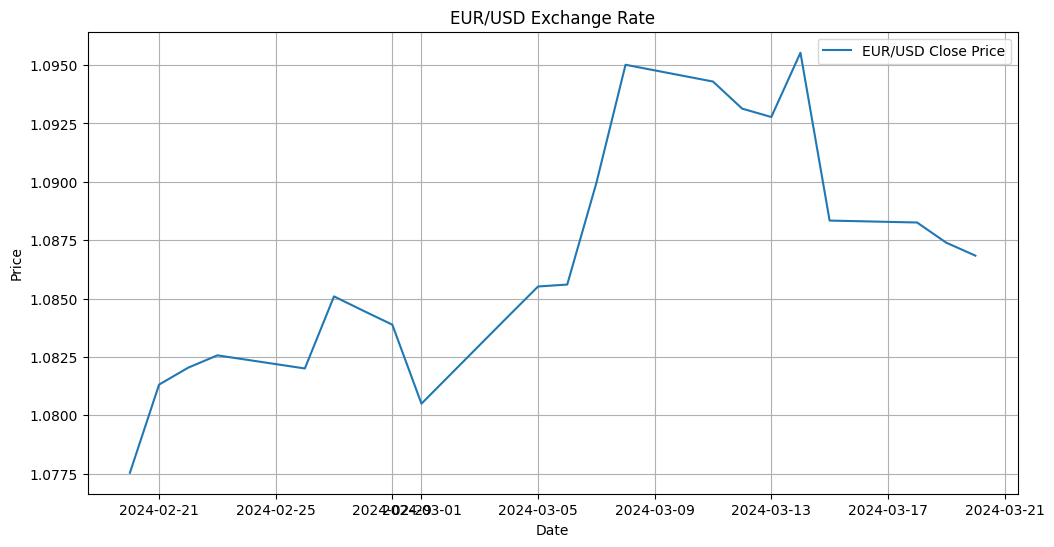

In [129]:
import datetime
import numpy as np
import pandas as pd
import yfinance as yf  # Import yfinance for data retrieval
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from IPython.display import display

%matplotlib inline

# Define the ticker symbol for EUR/USD
ticker_symbol = 'EURUSD=X'
ticker_interval = '1d' # change this to adjust granularity and train a separate model on that granularity. Options: 15m, 30m, 1h, 1d.
ticker_period = '5y' # ! 1d granularity doesn't seem to work with this regardless of data length (90d, 1y, 3y, 5y, max). !

# ! Not using this because higher granularity is not available. !
# Define the date range.
# d1 = datetime.datetime(2023, 7, 25)
# d2 = datetime.datetime(2023, 9, 21)

try:
    # fetching last 60 days of data with 15min granularity because-
    # i thought it'll be more optimal to train the model on.
    data = yf.download(ticker_symbol, period='1mo',
                       interval=ticker_interval, progress=False)

    # Display the first few rows of the data
    display(data.head())

    # You can now work with the 'data' DataFrame for your analysis or plotting.
    
    # Example: Plotting the Close prices
    plt.figure(figsize=(12, 6))
    plt.plot(data['Close'], label='EUR/USD Close Price')
    plt.title('EUR/USD Exchange Rate')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
    
except Exception as e:
    print(f"An error occurred: {str(e)}")


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-02-20,0.92804,0.92263,0.92915,0.92804,0.92804,0
2024-02-21,0.92480,0.92400,0.92662,0.92480,0.92480,0
2024-02-22,0.92418,0.91859,0.92549,0.92418,0.92418,0
2024-02-23,0.92373,0.92256,0.92475,0.92373,0.92373,0
2024-02-26,0.92425,0.92089,0.92478,0.92421,0.92421,0


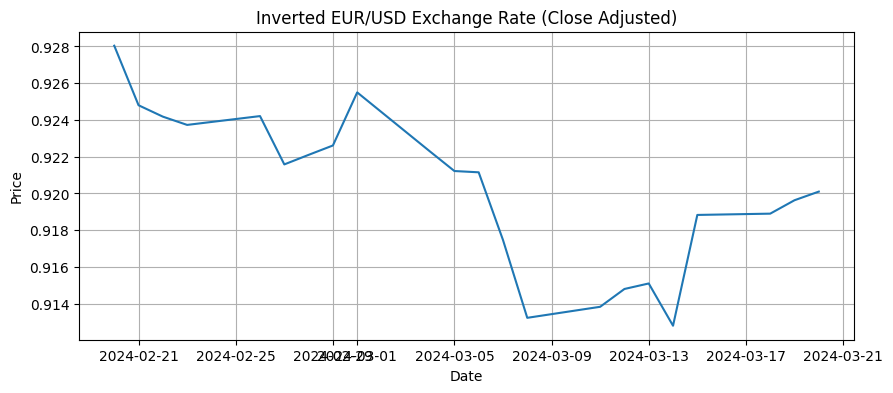

In [130]:
# Put data into Pandas Dataframe
df = pd.DataFrame(data)
df[['Open','High','Low','Close','Adj Close']] = df[['Open','High','Low','Close','Adj Close']].apply(lambda x: 1.0/x)
# Display the first few rows of the DataFrame
display(df.head())

# Plot the 'Close Adjusted' column
plt.figure(figsize=(10, 4))
plt.plot(df['Adj Close'], label='Inverted Close Adjusted Price')
plt.title('Inverted EUR/USD Exchange Rate (Close Adjusted)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

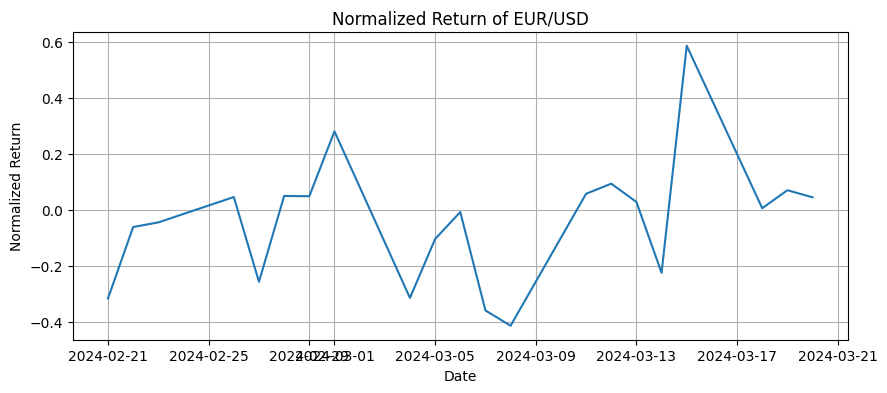

In [131]:
# Normalize aclose value and plot 'return' column
df['Return'] = df['Adj Close'] - df['Adj Close'].shift(1)
return_range = df['Return'].max() - df['Return'].min()
df['Return'] = df['Return'] / return_range

plt.figure(figsize=(10, 4))
plt.plot(df['Return'], label='Return')
plt.title('Normalized Return of EUR/USD')
plt.xlabel('Date')
plt.ylabel('Normalized Return')
plt.grid(True)
plt.show()


In [132]:
# Make label, 1 as rising price, 0 as falling price
df['Label'] = df['Return'].shift(-1)
df['Label'] = df['Label'].apply(lambda x: 1 if x > 0.0 else 0)

# Display the tail of the DataFrame with labels
df.tail()

,Open,High,Low,Close,Adj Close,Volume,Return,Label
Date,,,,,,,,
2024-03-14,0.91280,0.91285,0.91877,0.91280,0.91280,0,-0.223953,1
2024-03-15,0.91883,0.91730,0.91964,0.91883,0.91883,0,0.587145,1
2024-03-18,0.91890,0.91680,0.91905,0.91890,0.91890,0,0.006821,1
2024-03-19,0.91963,0.91930,0.92293,0.91963,0.91963,0,0.071075,1
2024-03-20,0.92010,0.92000,0.92070,0.92010,0.92010,0,0.045769,0


In [133]:

# Reset the index of the DataFrame
df.reset_index(drop=True, inplace=True)

n_features = 13  # number of features

train_x = np.array([]).reshape([-1, n_features])
train_y = np.array([]).reshape([-1, 1])

# Check if 'Label' is in the columns of your DataFrame
if 'Label' not in df.columns:
    print("The 'Label' column does not exist in your DataFrame.")
else:
    for index, row in df.iterrows():
        i = df.index.get_loc(index)
        if i < n_features:
            continue

        _x = np.array(df[i - n_features + 1:i + 1]['Return']).T.reshape([1, -1])
        print(df)
        _y = df.loc[i, 'Label']  # Use 'loc' method to access DataFrame values

        train_x = np.vstack((train_x, _x))
        train_y = np.vstack((train_y, _y))

    # Reshape train_y to 1D array
    train_y = train_y.reshape(-1)

    print(train_x.shape)
    print(train_y.shape)
    print('%% of Class 0: %f' % (np.count_nonzero(train_y == 0) / float(len(train_y))))
    print('%% of Class 1: %f' % (np.count_nonzero(train_y == 1) / float(len(train_y))))


       Open     High      Low    Close  Adj Close  Volume    Return  Label
0   0.92804  0.92263  0.92915  0.92804    0.92804       0       NaN      0
1   0.92480  0.92400  0.92662  0.92480    0.92480       0 -0.315491      0
2   0.92418  0.91859  0.92549  0.92418    0.92418       0 -0.060367      0
3   0.92373  0.92256  0.92475  0.92373    0.92373       0 -0.043819      1
4   0.92425  0.92089  0.92478  0.92421    0.92421       0  0.046743      0
5   0.92158  0.92029  0.92305  0.92158    0.92158       0 -0.256089      1
6   0.92210  0.92190  0.92604  0.92210    0.92210       0  0.050631      1
7   0.92261  0.92116  0.92544  0.92261    0.92261       0  0.049661      1
8   0.92550  0.92238  0.92599  0.92550    0.92550       0  0.281403      0
9   0.92228  0.92026  0.92263  0.92228    0.92228       0 -0.313532      0
10  0.92122  0.91951  0.92228  0.92122    0.92122       0 -0.103215      0
11  0.92115  0.91625  0.92226  0.92115    0.92115       0 -0.006816      0
12  0.91747  0.91400  0.9

In [134]:
# Define Model and fit
# Here we use 95% of data for training, and last 5% for testing

from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=0, learning_rate=0.015, n_estimators=15000)

train_len = int(len(train_x)*0.95)
clf.fit(train_x[:train_len], train_y[:train_len])

accuracy = clf.score(train_x[train_len:], train_y[train_len:])
print('Testing Accuracy: %f' % accuracy)

Testing Accuracy: 0.000000


,Return,Label,Pred,Won,Pnl,Equity


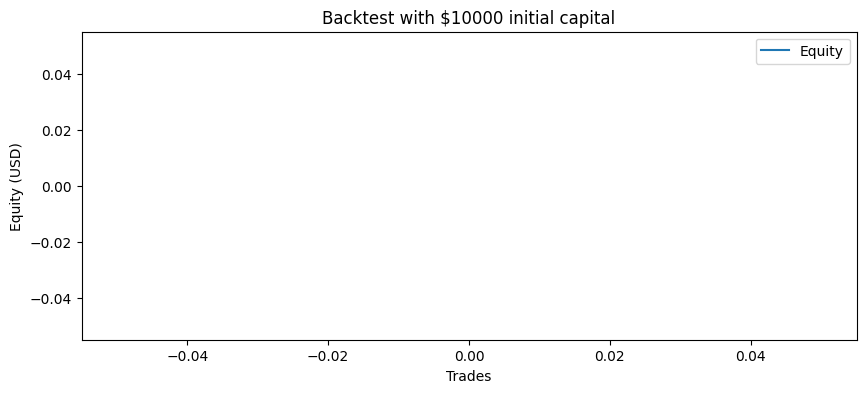

In [135]:
# Predict test data

pred = clf.predict(train_x[train_len:])


# Calculate equity..

contracts  = 10000.0
commission = 0.0


df_trade = pd.DataFrame(train_x[train_len:,-1], columns=['Return'])
df_trade['Label']  = train_y[train_len:]
df_trade['Pred']   = pred
df_trade['Won']    = df_trade['Label'] == df_trade['Pred']
df_trade['Return'] = df_trade['Return'].shift(-1) * return_range
df_trade.drop(df_trade.index[len(df_trade)-1], inplace=True)

def calc_profit(row):
    if row['Won']:
        return abs(row['Return'])*contracts - commission
    else:
        return -abs(row['Return'])*contracts - commission

df_trade['Pnl'] = df_trade.apply(lambda row: calc_profit(row), axis=1)
df_trade['Equity'] = df_trade['Pnl'].cumsum()

display(df_trade.tail())
df_trade.plot(y='Equity', figsize=(10,4), title='Backtest with $10000 initial capital')
plt.xlabel('Trades')
plt.ylabel('Equity (USD)')
for r in df_trade.iterrows():
    if r[1]['Won']:
        plt.axvline(x=r[0], linewidth=0.5, alpha=0.8, color='g')
    else:
        plt.axvline(x=r[0], linewidth=0.5, alpha=0.8, color='r')

In [136]:
# Calculate summary of trades

n_win_trades = float(df_trade[df_trade['Pnl']>0.0]['Pnl'].count())
n_los_trades = float(df_trade[df_trade['Pnl']<0.0]['Pnl'].count())
print("Net Profit            : $%.2f" % float(df_trade.tail(1)['Equity'].iloc[0]))
print("Number Winning Trades : %d" % n_win_trades)
print("Number Losing Trades  : %d" % n_los_trades)
print("Percent Profitable    : %.2f%%" % (100*n_win_trades/(n_win_trades + n_los_trades)))
print("Avg Win Trade         : $%.3f" % df_trade[df_trade['Pnl']>0.0]['Pnl'].mean())
print("Avg Los Trade         : $%.3f" % df_trade[df_trade['Pnl']<0.0]['Pnl'].mean())
print("Largest Win Trade     : $%.3f" % df_trade[df_trade['Pnl']>0.0]['Pnl'].max())
print("Largest Los Trade     : $%.3f" % df_trade[df_trade['Pnl']<0.0]['Pnl'].min())
print("Profit Factor         : %.2f" % abs(df_trade[df_trade['Pnl']>0.0]['Pnl'].sum()/df_trade[df_trade['Pnl']<0.0]['Pnl'].sum()))

df_trade['Pnl'].hist(bins=20)

IndexError: single positional indexer is out-of-bounds

In [ ]:
import os

# Get the parent directory of the notebook's directory
parent_directory = os.path.dirname(os.getcwd())

# Define the directory path for saving the model within the "models" directory
model_directory = os.path.join(parent_directory, "models")

# Create the "models" directory if it doesn't exist
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

# Define the file path for saving the model
model_filename = os.path.join(model_directory, f"{ticker_interval}.h5")

# Save the trained model to a file
joblib.dump(clf, model_filename)

# Print a message to confirm the model has been saved
print("Trained model saved to", model_filename)

Trained model saved to c:\Users\infin\OneDrive\Desktop\pyre-trader\models\1h.h5
